<a href="https://colab.research.google.com/github/Sarthak3003/DSP-FY-Project/blob/main/Dental_Caries_DSPA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import OneHotEncoder

#for prediction
import tensorflow as tf
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix

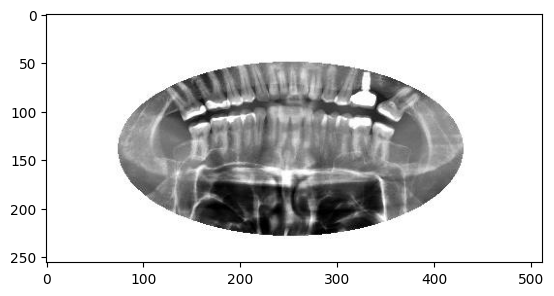

In [ ]:
#visualize the data
example_path = os.listdir('/content/drive/MyDrive/Dental-Radiography-Dataset/train')[0]
example_img = plt.imread(f'/content/drive/MyDrive/Dental-Radiography-Dataset/train/{example_path}')
plt.imshow(example_img, cmap= 'gray')

In [ ]:
#loading annotations of valid data

df_valid = pd.read_csv('/content/drive/MyDrive/Dental-Radiography-Dataset/valid/_annotations.csv')
df_valid.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,0355_jpg.rf.e3e6daab192a51e715ef9fc3394f2a76.jpg,512,256,Fillings,186,85,209,129
1,0355_jpg.rf.e3e6daab192a51e715ef9fc3394f2a76.jpg,512,256,Fillings,167,93,188,128
2,0355_jpg.rf.e3e6daab192a51e715ef9fc3394f2a76.jpg,512,256,Fillings,143,93,170,130
3,0355_jpg.rf.e3e6daab192a51e715ef9fc3394f2a76.jpg,512,256,Fillings,127,132,155,182
4,0355_jpg.rf.e3e6daab192a51e715ef9fc3394f2a76.jpg,512,256,Implant,313,85,330,123


In [ ]:
df_valid['cropped_image_width'] = df_valid['xmax']-df_valid['xmin']
df_valid['cropped_image_height'] = df_valid['ymax']-df_valid['ymin']
df_valid['Area'] = df_valid['cropped_image_width']*df_valid['cropped_image_height']
df_valid.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,cropped_image_width,cropped_image_height,Area
0,0355_jpg.rf.e3e6daab192a51e715ef9fc3394f2a76.jpg,512,256,Fillings,186,85,209,129,23,44,1012
1,0355_jpg.rf.e3e6daab192a51e715ef9fc3394f2a76.jpg,512,256,Fillings,167,93,188,128,21,35,735
2,0355_jpg.rf.e3e6daab192a51e715ef9fc3394f2a76.jpg,512,256,Fillings,143,93,170,130,27,37,999
3,0355_jpg.rf.e3e6daab192a51e715ef9fc3394f2a76.jpg,512,256,Fillings,127,132,155,182,28,50,1400
4,0355_jpg.rf.e3e6daab192a51e715ef9fc3394f2a76.jpg,512,256,Implant,313,85,330,123,17,38,646


In [ ]:
df_valid.columns


Index(['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax',
       'cropped_image_width', 'cropped_image_height', 'Area'],
      dtype='object')

In [ ]:
df_valid = df_valid[(df_valid.Area >= df_valid.Area.quantile(0.25)) & (df_valid.Area <= df_valid.Area.quantile(0.75))]

In [ ]:
#loading annotations for test data

df_test = pd.read_csv('/content/drive/MyDrive/Dental-Radiography-Dataset/test/_annotations.csv')

df_test['cropped_image_width'] = df_test['xmax']-df_test['xmin']
df_test['cropped_image_height'] = df_test['ymax']-df_test['ymin']
df_test['Area'] = df_test['cropped_image_width']*df_test['cropped_image_height']

df_test = df_test[(df_test.Area >= df_test.Area.quantile(0.25)) & (df_test.Area <= df_test.Area.quantile(0.75))]
df_test.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,cropped_image_width,cropped_image_height,Area
5,0136_jpg.rf.03e2aec8ec77594665dd1abc68d47bd3.jpg,512,256,Fillings,164,158,195,197,31,39,1209
8,0136_jpg.rf.03e2aec8ec77594665dd1abc68d47bd3.jpg,512,256,Fillings,331,111,354,150,23,39,897
9,0136_jpg.rf.03e2aec8ec77594665dd1abc68d47bd3.jpg,512,256,Fillings,310,110,332,152,22,42,924
10,0136_jpg.rf.03e2aec8ec77594665dd1abc68d47bd3.jpg,512,256,Fillings,185,111,204,152,19,41,779
13,0507_jpg.rf.07ca548c6eb4f61c76f1629e7bc26fa4.jpg,512,256,Fillings,251,91,272,148,21,57,1197


In [ ]:
#loading annotations of train data

df_train = pd.read_csv('/content/drive/MyDrive/Dental-Radiography-Dataset/train/_annotations.csv')

df_train['cropped_image_width'] = df_train['xmax']-df_train['xmin']
df_train['cropped_image_height'] = df_train['ymax']-df_train['ymin']
df_train['Area'] = df_train['cropped_image_width']*df_train['cropped_image_height']

df_train = df_train[(df_train.Area >= df_train.Area.quantile(0.25)) & (df_train.Area <= df_train.Area.quantile(0.75))]
df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,cropped_image_width,cropped_image_height,Area
0,0674_jpg.rf.e02a155a0c135687b9301ff9a20d220a.jpg,512,256,Implant,175,116,206,153,31,37,1147
3,0674_jpg.rf.e02a155a0c135687b9301ff9a20d220a.jpg,512,256,Implant,302,126,329,175,27,49,1323
4,0674_jpg.rf.e02a155a0c135687b9301ff9a20d220a.jpg,512,256,Implant,335,114,360,154,25,40,1000
7,0674_jpg.rf.e02a155a0c135687b9301ff9a20d220a.jpg,512,256,Fillings,311,58,330,109,19,51,969
13,0271_jpg.rf.e18d2d727c6d0c029f5b6024f39058d6.jpg,512,256,Fillings,140,114,161,164,21,50,1050


In [ ]:
df_train.isnull().sum()

filename                0
width                   0
height                  0
class                   0
xmin                    0
ymin                    0
xmax                    0
ymax                    0
cropped_image_width     0
cropped_image_height    0
Area                    0
dtype: int64

In [ ]:
def get_image_label_lists(df, dirname):

  filenames = [filename for filename in os.listdir(dirname) if filename.endswith(".jpg")]
  image_list = []
  label_list = []

  # Define the desired image size
  desired_width = 50
  desired_height = 50
  for filename in filenames:
      img_df = df[df.filename == filename]
      image = cv2.imread(os.path.join(dirname,filename))
      # Convert the image to grayscale
      gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      # Iterate over each row in the dataframe
      for index, row in img_df.iterrows():
          # Extract crop parameters
          xmin = row['xmin']
          xmax = row['xmax']
          ymin = row['ymin']
          ymax = row['ymax']
          # Crop the image
          cropped_image = gray_image[ymin:ymax, xmin:xmax]
          # Resize the cropped image
          resized_image = cv2.resize(cropped_image, (desired_width, desired_height))
          image_list.append(resized_image)
          label_list.append(row['class'])

  return np.array(image_list), np.array(label_list)

In [ ]:
dirname_test = '/content/drive/MyDrive/Dental-Radiography-Dataset/test'

image_list_test, label_list_test = get_image_label_lists(df_test, dirname_test)
print(image_list_test.shape)
print(label_list_test.shape)

(237, 50, 50)
(237,)


In [ ]:
dirname_train = '/content/drive/MyDrive/Dental-Radiography-Dataset/train'

image_list_train, label_list_train = get_image_label_lists(df_train, dirname_train)
print(image_list_train.shape)
print(label_list_train.shape)

(4023, 50, 50)
(4023,)


In [ ]:
dirname_valid = '/content/drive/MyDrive/Dental-Radiography-Dataset/valid'

image_list_valid, label_list_valid = get_image_label_lists(df_valid, dirname_valid)
print(image_list_valid.shape)
print(label_list_valid.shape)

(392, 50, 50)
(392,)


In [ ]:
# encode the labels

def encode_labels(label_list):
  encoder = OneHotEncoder()
  labels_reshaped = label_list.reshape(-1, 1)
  one_hot_encoded = encoder.fit_transform(labels_reshaped)
  one_hot_encoded_array = one_hot_encoded.toarray()

  return one_hot_encoded_array

In [ ]:
label_y_train = encode_labels(label_list_train)
print(label_y_train.shape)

label_y_test = encode_labels(label_list_test)
print(label_y_test.shape)

label_y_valid = encode_labels(label_list_valid)
print(label_y_valid.shape)

(4023, 4)
(237, 4)
(392, 4)


In [ ]:
train_data =  image_list_train
train_labels = label_y_train
valid_data = image_list_valid
valid_labels = label_y_valid

# Define the model architecture
def model_1():
  model = tf.keras.Sequential([
      layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(50, 50, 1)),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(4, activation='softmax')
  ])

  return model


In [ ]:
model_1 = model_1()
model_1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 24, 24, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 11, 11, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_5 (Flatten)         (None, 7744)              0         
                                                                 
 dense_10 (Dense)            (None, 128)              

In [ ]:
# Compile the model
model_1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
es = EarlyStopping(patience=15, monitor='val_accuracy', restore_best_weights=True)

history = model_1.fit(train_data, train_labels, epochs=10, batch_size=32, validation_data=(valid_data,valid_labels))

Epoch 1/10
126/126 [==============================] - 62s 64ms/step - loss: 3.0952 - accuracy: 0.7226 - val_loss: 0.3478 - val_accuracy: 0.8724
Epoch 2/10
126/126 [==============================] - 7s 55ms/step - loss: 0.3820 - accuracy: 0.8623 - val_loss: 0.3198 - val_accuracy: 0.8903
Epoch 3/10
126/126 [==============================] - 8s 64ms/step - loss: 0.2986 - accuracy: 0.8891 - val_loss: 0.3640 - val_accuracy: 0.8827
Epoch 4/10
126/126 [==============================] - 7s 54ms/step - loss: 0.2221 - accuracy: 0.9210 - val_loss: 0.3033 - val_accuracy: 0.9107
Epoch 5/10
126/126 [==============================] - 8s 64ms/step - loss: 0.1749 - accuracy: 0.9369 - val_loss: 0.2534 - val_accuracy: 0.9260
Epoch 6/10
126/126 [==============================] - 8s 60ms/step - loss: 0.1134 - accuracy: 0.9610 - val_loss: 0.2807 - val_accuracy: 0.9260
Epoch 7/10
126/126 [==============================] - 7s 59ms/step - loss: 0.0857 - accuracy: 0.9697 - val_loss: 0.2947 - val_accuracy: 0.931

In [ ]:
predicted_classes = model.predict(image_list_test)

8/8 [==============================] - 0s 14ms/step


In [ ]:
# Convert predicted probabilities into class labels
predicted_labels = np.argmax(predicted_classes, axis=1)

# Map class labels to class names
class_names = ['Cavity', 'Fillings', 'Impacted Tooth', 'Implant']
predicted_class_names = [class_names[label] for label in predicted_labels]

# Print the predicted class names
print(predicted_class_names)

['Impacted Tooth', 'Impacted Tooth', 'Impacted Tooth', 'Impacted Tooth', 'Impacted Tooth', 'Impacted Tooth', 'Impacted Tooth', 'Impacted Tooth', 'Impacted Tooth', 'Impacted Tooth', 'Fillings', 'Fillings', 'Impacted Tooth', 'Impacted Tooth', 'Fillings', 'Impacted Tooth', 'Impacted Tooth', 'Impacted Tooth', 'Impacted Tooth', 'Impacted Tooth', 'Impacted Tooth', 'Impacted Tooth', 'Impacted Tooth', 'Impacted Tooth', 'Impacted Tooth', 'Impacted Tooth', 'Impacted Tooth', 'Fillings', 'Impacted Tooth', 'Impacted Tooth', 'Impacted Tooth', 'Impacted Tooth', 'Impacted Tooth', 'Impacted Tooth', 'Impacted Tooth', 'Impacted Tooth', 'Impacted Tooth', 'Impacted Tooth', 'Impacted Tooth', 'Impacted Tooth', 'Impacted Tooth', 'Impacted Tooth', 'Impacted Tooth', 'Impacted Tooth', 'Impacted Tooth', 'Impacted Tooth', 'Impacted Tooth', 'Impacted Tooth', 'Impacted Tooth', 'Impacted Tooth', 'Impacted Tooth', 'Impacted Tooth', 'Impacted Tooth', 'Impacted Tooth', 'Impacted Tooth', 'Impacted Tooth', 'Impacted Tooth

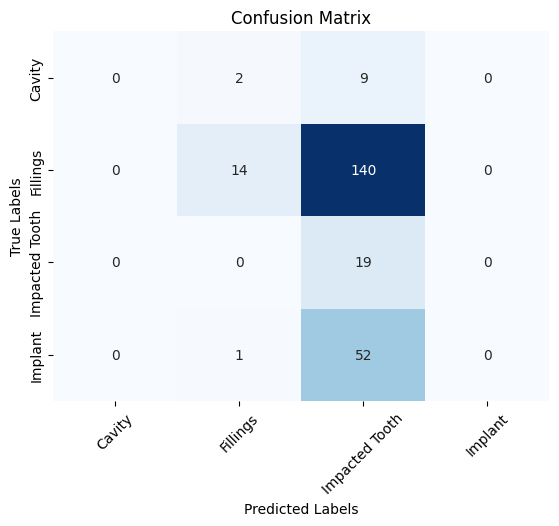

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(label_list_test, predicted_class_names)

# Define class names (adjust according to your specific class names)
class_names = ['Cavity', 'Fillings', 'Impacted Tooth', 'Implant']

# Create a figure and axis
fig, ax = plt.subplots()

# Create a heatmap from the confusion matrix
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)

# Set axis labels and title
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')

# Set x-axis tick labels
heatmap.set_xticklabels(class_names)
heatmap.set_yticklabels(class_names)

# Rotate x-axis tick labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.show()